c:\Users\Daniel Vegaam\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\Daniel Vegaam\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\Daniel Vegaam\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\Daniel Vegaam\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\Daniel Vegaam\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


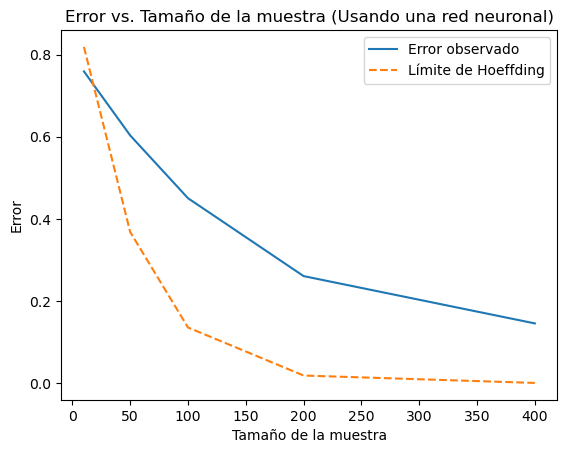

In [5]:
import gzip #Para los dataset que estan en formato gz
import os 
from os.path import isfile, join #Para rutas y archivos
import numpy as np #Para crear arrays
import matplotlib.pyplot as plt
import random
import tensorflow as tf #Para construir y entrenar redes neuronales
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score #Para calcular la presición del modelo

dataset = './dataset'

#Función que devuelve los paths de los archivos en el directorio
def listFiles(dataset):
    return [join(dataset,file) for file in os.listdir(dataset) if isfile(join(dataset, file))]

#Funcion que lee los archivos comprimidos (gz) de MNIST
def getImages(dataset):
    for file in listFiles(dataset):
        if "train-images" in file:
            with gzip.open(file, 'rb') as data:
                _= int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                train_images = data.read()
                x_train = np.frombuffer(train_images, dtype = np.uint8)
                x_train = x_train.reshape((num_images, rows, cols))
        elif 'train-labels' in file:
            with gzip.open(file, 'rb') as data:
                train_labels = data.read()[8:]
                y_train = np.frombuffer(train_labels, dtype = np.uint8)

        if "t10k-images" in file:
            with gzip.open(file, 'rb') as data:
                _= int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                test_images = data.read()
                x_test = np.frombuffer(test_images, dtype = np.uint8)
                x_test = x_test.reshape((num_images, rows, cols))
        elif 't10k-labels' in file:
            with gzip.open(file, 'rb') as data:
                test_labels = data.read()[8:]
                y_test = np.frombuffer(test_labels, dtype = np.uint8)
    return x_train, y_train, x_test, y_test



#PREPARACIÓN DE LOS DATOS
x_train, y_train, x_test, y_test = getImages(dataset)



# Aplanar las imágenes para poder usarlas en el modelo de regresión logística
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Normalizar las imágenes
x_train_flat = x_train_flat / 255.0
x_test_flat = x_test_flat / 255.0

# Convertir etiquetas a formato one-hot
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


#Construye una red neuronal simple
def build_model():
    model = Sequential([
        Flatten(input_shape=(x_train_flat.shape[1],)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')  # 10 clases para MNIST
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



#Función para entrenar y evaluar un modelo
def train_and_evaluate(sample_size):
    # Selecciona una muestra aleatoria de imágenes
    indices = random.sample(range(len(x_train_flat)), sample_size)
    x_sample = x_train_flat[indices]
    y_sample = y_train_cat[indices]
    
    # Construir y entrenar el modelo
    model = build_model()
    model.fit(x_sample, y_sample, epochs=5, verbose=0)
    
    # Evalúa el modelo en el conjunto de prueba
    y_pred_prob = model.predict(x_test_flat)
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    error = 1 - accuracy
    
    return error



# Aplicación de la desigualdad de Hoeffding
def apply_hoeffding(sample_sizes):
    errors = []
    bounds = []
    epsilon = 0.1
    
    for size in sample_sizes:
        error = train_and_evaluate(size)
        errors.append(error)
        
        # Cálculo del límite de Hoeffding
        bound = np.exp(-2 * epsilon ** 2 * size)
        bounds.append(bound)
    
    return errors, bounds



# Prueba con tamaños de muestra crecientes
sample_sizes = [10, 50, 100, 200, 400]
errors, bounds = apply_hoeffding(sample_sizes)

# Grafica los errores y los límites de Hoeffding
plt.plot(sample_sizes, errors, label='Error observado')
plt.plot(sample_sizes, bounds, label='Límite de Hoeffding', linestyle='--')
plt.xlabel('Tamaño de la muestra')
plt.ylabel('Error')
plt.title('Error vs. Tamaño de la muestra (Usando una red neuronal)')
plt.legend()
plt.show()